In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

#### EDA

- Load the Data

In [4]:
df = pd.read_csv("data/housing.csv")

In [5]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


- Plotting histogram of `median_house_value`

<AxesSubplot:xlabel='median_house_value', ylabel='Density'>

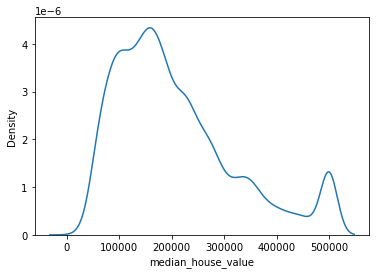

In [6]:
sns.distplot(df['median_house_value'], hist = False)

- __The plot is right skewed or has long right tail, which means some houses are expensive and it shifts the mean of `median_house_value` towards right__

### Selecting Features

In [7]:
cols = ['latitude', 'longitude', 'housing_median_age','total_rooms','total_bedrooms',
        'population', 'households', 'median_income','median_house_value']

In [8]:
df = df[cols]

### Question 1

__Find a feature with missing values. How many missing values does it have?__


In [9]:
df.isna().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

### Question 2

__What's the median (50% percentile) for variable 'population'?__

In [10]:
df['population'].median()

1166.0

#### Split the data

- Shuffle the initial dataset, use seed 42.
- Split your data in train/val/test sets, with 60%/20%/20% distribution.
- Make sure that the target value ('median_house_value') is not in your dataframe.
- Apply the log transformation to the median_house_value variable using the np.log1p() function.

In [11]:
n = len(df)

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

idx = np.arange(n)

np.random.seed(42)
np.random.shuffle(idx)

df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

X_col = ['latitude', 'longitude', 'housing_median_age','total_rooms','total_bedrooms',
        'population', 'households', 'median_income']
y_col = ['median_house_value']

X_train = df_train[X_col]
y_train = np.log1p(df_train[y_col])

X_val = df_val[X_col]
y_val = np.log1p(df_val[y_col])

X_test = df_test[X_col]
y_test = np.log1p(df_test[y_col])

### Question 3

- We need to deal with missing values for the column from Q1.
- We have two options: fill it with 0 or with the mean of this variable.
- Try both options. For each, train a linear regression model without regularization using the code from the lessons.
- For computing the mean, use the training only!
- Use the validation dataset to evaluate the models and compare the RMSE of each option.
- Round the RMSE scores to 2 decimal digits using round(score, 2)
- Which option gives better RMSE?

- __`total_bedrooms`__ column has a missing value.

- __first option__ Replace `nan's` in column `total_bedrooms` with 0

In [12]:
X_train_filled_zero = X_train.copy()
X_val_filled_zero = X_val.copy()
X_test_filled_zero = X_test.copy()

X_train_filled_mean = X_train.copy()
X_val_filled_mean = X_val.copy()
X_test_filled_mean = X_test.copy()

In [13]:
X_train_filled_zero['total_bedrooms'] = X_train_filled_zero['total_bedrooms'].fillna(0)
X_val_filled_zero['total_bedrooms'] = X_val_filled_zero['total_bedrooms'].fillna(0)
X_test_filled_zero['total_bedrooms'] = X_test_filled_zero['total_bedrooms'].fillna(0)

mean = round(X_train['total_bedrooms'].mean(),2)
X_train_filled_mean['total_bedrooms'] = X_train_filled_mean['total_bedrooms'].fillna(mean)
X_val_filled_mean['total_bedrooms'] = X_val_filled_mean['total_bedrooms'].fillna(mean)
X_test_filled_mean['total_bedrooms'] = X_test_filled_mean['total_bedrooms'].fillna(mean)

In [14]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [15]:
def rmse(y, y_pred):
    error = y_val['median_house_value']-y_val_pred[0]
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [16]:
w_0, w = train_linear_regression(X_train_filled_zero,y_train)
y_val_pred = w_0 + X_val_filled_zero.dot(w)

rmse_0 = round(rmse(y_val, y_val_pred),2)

In [17]:
w_0, w = train_linear_regression(X_train_filled_mean,y_train)
y_val_pred = w_0 + X_val_filled_mean.dot(w)

rmse_mu = round(rmse(y_val, y_val_pred),2)

In [18]:
if rmse_0>rmse_mu:
    print("Filling missing value with mean is better")
elif rmse_0<rmse_mu:
    print("Filling missing value with 0 is better")
else:
    print("Both rmse are equal")
print(rmse_0)
print(rmse_mu)

Both rmse are equal
0.33
0.33


### Question 4
- Now let's train a regularized linear regression.
- For this question, fill the NAs with 0.
- Try different values of r from this list: [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10].
- Use RMSE to evaluate the model on the validation dataset.
- Round the RMSE scores to 2 decimal digits.
- Which r gives the best RMSE?

In [19]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [20]:
r = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]
for i in range(len(r)):
    w0, w = train_linear_regression_reg(X_train_filled_zero, y_train, r=r[i])
    y_val_pred = w_0 + X_val_filled_zero.dot(w)
    rmse_val = round(rmse(y_val, y_val_pred),2)
    print("RMSE of r =", r[i], "is = ", rmse_val)

RMSE of r = 0 is =  0.34
RMSE of r = 1e-06 is =  0.34
RMSE of r = 0.0001 is =  0.34
RMSE of r = 0.001 is =  0.34
RMSE of r = 0.01 is =  0.4
RMSE of r = 0.1 is =  1.52
RMSE of r = 1 is =  6.84
RMSE of r = 5 is =  10.28
RMSE of r = 10 is =  10.97


### Question 5

- We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
- Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
- For each seed, do the train/validation/test split with 60%/20%/20% distribution.
- Fill the missing values with 0 and train a model without regularization.
- For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
- What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
- Round the result to 3 decimal digits (round(std, 3))


    Note: Standard deviation shows how different the values are. If it's low, then all values are approximately the same. If it's high, the values are different. If standard deviation of scores is low, then our model is stable.

In [21]:
def split_data(df, seeding):
    n = len(df)
    
    df['total_bedrooms'] = df['total_bedrooms'].fillna(0)
    
    n_val = int(n * 0.2)
    n_test = int(n * 0.2)
    n_train = n - n_val - n_test

    idx = np.arange(n)

    np.random.seed(seeding)
    np.random.shuffle(idx)

    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train+n_val]]
    df_test = df.iloc[idx[n_train+n_val:]]

    X_col = ['latitude', 'longitude', 'housing_median_age','total_rooms','total_bedrooms',
        'population', 'households', 'median_income']
    y_col = ['median_house_value']

    X_train = df_train[X_col]
    y_train = np.log1p(df_train[y_col])

    X_val = df_val[X_col]
    y_val = np.log1p(df_val[y_col])

    X_test = df_test[X_col]
    y_test = np.log1p(df_test[y_col])
    
    w_0, w = train_linear_regression(X_train,y_train)
    y_val_pred = w_0 + X_val.dot(w)
    
    error = (y_val['median_house_value']-y_val_pred[0]).values
    RMSE = ((error**2).mean())**1/2
    return RMSE

In [22]:
rmses = []
seeding =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

for s in seeding:
    r = split_data(df, s)
    rmses.append(r)
print(round(np.std(rmses),3))

0.001


## Question 6
- Split the dataset like previously, use seed 9.
- Combine train and validation datasets.
- Fill the missing values with 0 and train a model with r=0.001.
- What's the RMSE on the test dataset?

In [49]:
def get_result(df):
    n = len(df)
    
    df['total_bedrooms'] = df['total_bedrooms'].fillna(0)
    
    n_val = int(n * 0.2)
    n_test = int(n * 0.2)
    n_train = n - n_val - n_test

    idx = np.arange(n)

    np.random.seed(seeding)
    np.random.shuffle(idx)

    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train+n_val]]
    df_test = df.iloc[idx[n_train+n_val:]]
    
    df_train = df_train.append(df_val)

    X_col = ['latitude', 'longitude', 'housing_median_age','total_rooms','total_bedrooms',
        'population', 'households', 'median_income']
    y_col = ['median_house_value']

    X_train = df_train[X_col]
    y_train = np.log1p(df_train[y_col])

    X_test = df_test[X_col]
    y_test = np.log1p(df_test[y_col])
    
    w_0, w = train_linear_regression_reg(X_train,y_train,r=0.001)
    y_test_pred = w_0 + X_test.dot(w)
    
    error = (y_test['median_house_value']-y_test_pred[0]).values
    RMSE = ((error**2).mean())**1/2
    return round(RMSE,3)

In [50]:
RMSE = get_result(df)
print(RMSE)

0.056
